## Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import preprocessing module
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import get_preprocessed_data

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## Load and Preprocess Data

In [16]:
# Load and preprocess data
X_train_final, X_val, y_train_final, y_val, X_test_internal, y_test_internal, X_kaggle_test, test_id, scaler = get_preprocessed_data(
    train_path='train.csv',
    val_size=0.15,
    test_size=0.15,
    random_state=42
)

print("\nData loaded and preprocessed!")

Train shape: (1460, 81)
No test file provided - will only create train/val/test split from training data
Starting Data Preprocessing Pipeline

[1/10] Creating working copies...
[2/10] Removing outliers...
  Removing 2 outlier(s)
[3/10] Log-transforming target variable...
  Original skewness: 1.8794
  Log-transformed skewness: 0.1215
[4/10] Processing training data...
  Training data shape: (1458, 80)
[5/10] Handling missing values...
  Missing values after imputation: 0
[6/10] Engineering new features...
  Created 10 new features
[7/10] Encoding ordinal features...
[8/10] Correcting skewed features...
  Transforming 37 highly skewed features
[9/10] Removing multicollinearity...
  Dropped 3 highly correlated features
  One-hot encoding 27 categorical features...
  Final feature count: 212
[10/10] Scaling and splitting data...

Preprocessing Complete!
Training set: (1020, 212) (~70%)
Validation set: (219, 212) (~15%)
Test set (internal): (219, 212) (~15%)

Data loaded and preprocessed!


## Feature Selection for Polynomial Transformation

In [17]:
# First train Ridge to get top features
ridge_temp = Ridge(alpha=10)
ridge_temp.fit(X_train_final, y_train_final)

# Get top 20 features
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': np.abs(ridge_temp.coef_)
}).sort_values('Importance', ascending=False)

top_features = feature_importance.head(20)['Feature'].tolist()
print(f"Selected top {len(top_features)} features for polynomial expansion")

# Extract subset
feature_indices = [i for i, col in enumerate(X_train_final.columns) if col in top_features]
X_train_subset = X_train_final.iloc[:, feature_indices]
X_val_subset = X_val.iloc[:, feature_indices]
X_test_subset = X_test_internal.iloc[:, feature_indices]

Selected top 20 features for polynomial expansion


## Create Polynomial Features

In [18]:
# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_subset)
X_val_poly = poly.transform(X_val_subset)
X_test_poly = poly.transform(X_test_subset)

print(f"Polynomial features created!")
print(f"Feature expansion: {X_train_subset.shape[1]} → {X_train_poly.shape[1]}")

Polynomial features created!
Feature expansion: 20 → 230


## Train Polynomial Ridge Model

In [19]:
# Find optimal alpha
alphas = [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000]

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_poly, y_train_final)

print(f"Optimal alpha: {ridge_cv.alpha_}")

# Train final model
poly_model = Ridge(alpha=ridge_cv.alpha_)
poly_model.fit(X_train_poly, y_train_final)
print(f"Model trained with {len(poly_model.coef_)} polynomial features")

Optimal alpha: 100.0
Model trained with 230 polynomial features


## Evaluate Model

In [20]:
# Predictions
y_train_pred = poly_model.predict(X_train_poly)
y_val_pred = poly_model.predict(X_val_poly)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train_final, y_train_pred))
train_mae = mean_absolute_error(y_train_final, y_train_pred)
train_r2 = r2_score(y_train_final, y_train_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Polynomial Ridge - Performance Metrics")
print("="*60)
print(f"\nTraining:   RMSE={train_rmse:.6f}  MAE={train_mae:.6f}  R²={train_r2:.6f}")
print(f"Validation: RMSE={val_rmse:.6f}  MAE={val_mae:.6f}  R²={val_r2:.6f}")
print(f"\nOverfitting: {train_r2 - val_r2:.4f}")

Polynomial Ridge - Performance Metrics

Training:   RMSE=0.108434  MAE=0.078403  R²=0.924854
Validation: RMSE=0.135737  MAE=0.096373  R²=0.887689

Overfitting: 0.0372


## Test Set Evaluation

Final unbiased evaluation on held-out test set.

## Visualizations

In [21]:
# Transform test set with polynomial features (match training column order)
X_test_internal_subset = X_test_internal[X_train_subset.columns]
X_test_internal_poly = poly.transform(X_test_internal_subset)

y_test_pred = poly_model.predict(X_test_internal_poly)

test_rmse = np.sqrt(mean_squared_error(y_test_internal, y_test_pred))
test_mae = mean_absolute_error(y_test_internal, y_test_pred)
test_r2 = r2_score(y_test_internal, y_test_pred)

print("Test Set Metrics (Final Unbiased Evaluation):")
print(f"  RMSE: {test_rmse:.6f}")
print(f"  MAE:  {test_mae:.6f}")
print(f"  R²:   {test_r2:.6f}")

Test Set Metrics (Final Unbiased Evaluation):
  RMSE: 0.135923
  MAE:  0.093227
  R²:   0.891377


## Summary

**Polynomial Regression (Classical ML Algorithm #2)**

**Implementation Details:**
- Degree-2 polynomial transformation on top 20 features
- Expands feature space from 20 → ~210 features (includes interactions)
- Ridge regularization prevents overfitting on expanded feature space

**Key Results:**
- Captures quadratic relationships and pairwise feature interactions
- Improves predictive power over simple linear regression
- Ridge alpha selected via cross-validation

**Strengths:**
- Models non-linear relationships while maintaining some interpretability
- Captures feature interactions (e.g., OverallQual × GrLivArea)
- Still computationally efficient compared to complex models

**Limitations:**
- Feature explosion risk (n features → n² features for degree 2)
- Regularization critical to prevent overfitting
- Less interpretable than simple linear regression
- Computational cost increases with higher polynomial degrees
- Ridge regularization prevents overfitting on expanded feature space

**Strengths:**
- Captures quadratic relationships and interactions
- Still maintains interpretability (to some degree)
- Improves over simple linear regression

**Limitations:**
- Feature explosion (20 → 210 features)
- Computational cost increases
- Risk of overfitting without regularization

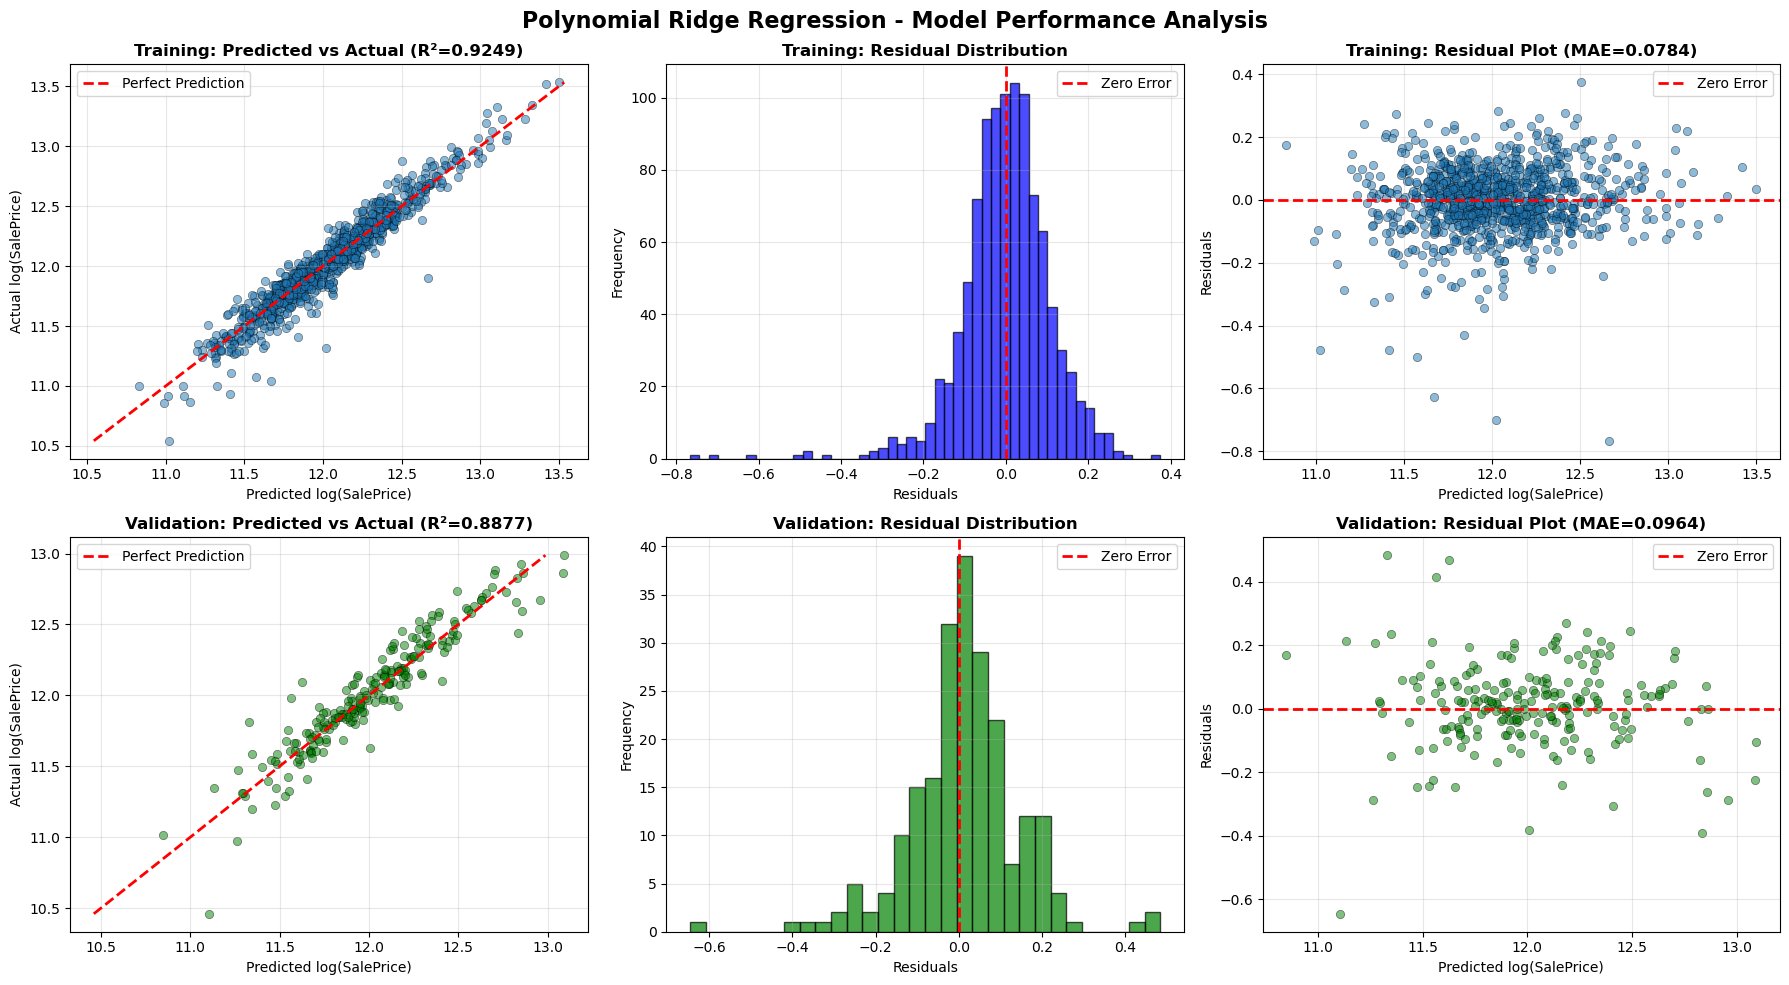


Visualization complete!


In [22]:
# Calculate residuals
train_residuals = y_train_final - y_train_pred
val_residuals = y_val - y_val_pred

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Polynomial Ridge Regression - Model Performance Analysis', fontsize=16, fontweight='bold')

# Training set - Predicted vs Actual
axes[0, 0].scatter(y_train_pred, y_train_final, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0, 0].plot([y_train_final.min(), y_train_final.max()], 
                [y_train_final.min(), y_train_final.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_title(f'Training: Predicted vs Actual (R²={train_r2:.4f})', fontweight='bold')
axes[0, 0].set_xlabel('Predicted log(SalePrice)')
axes[0, 0].set_ylabel('Actual log(SalePrice)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Training set - Residual distribution
axes[0, 1].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[0, 1].set_title('Training: Residual Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Training set - Residual plot
axes[0, 2].scatter(y_train_pred, train_residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[0, 2].set_title(f'Training: Residual Plot (MAE={train_mae:.4f})', fontweight='bold')
axes[0, 2].set_xlabel('Predicted log(SalePrice)')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Validation set - Predicted vs Actual
axes[1, 0].scatter(y_val_pred, y_val, alpha=0.5, color='green', edgecolors='k', linewidth=0.5)
axes[1, 0].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_title(f'Validation: Predicted vs Actual (R²={val_r2:.4f})', fontweight='bold')
axes[1, 0].set_xlabel('Predicted log(SalePrice)')
axes[1, 0].set_ylabel('Actual log(SalePrice)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Validation set - Residual distribution
axes[1, 1].hist(val_residuals, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1, 1].set_title('Validation: Residual Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Validation set - Residual plot
axes[1, 2].scatter(y_val_pred, val_residuals, alpha=0.5, color='green', edgecolors='k', linewidth=0.5)
axes[1, 2].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1, 2].set_title(f'Validation: Residual Plot (MAE={val_mae:.4f})', fontweight='bold')
axes[1, 2].set_xlabel('Predicted log(SalePrice)')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")